In [1]:
# Preamble: we need math functions and the numpy library

import math
import numpy as np

## Model parameter calculations 

Using this script you can calculate the viscosity, density and yield strength parameters for the underworld layered-oceanic lithosphere models assuming a half-space cooling model. The assumptions needed to scale the model are given first: reference values, crustal thicknesses, the model size etc. 

Viscosity is taken from Karato & Wu, 1993, assuming wet dislocation creep. 


In [2]:
# Age in Myr:                              timeMyrs
# Oceanic crust thickness in km:           crustThickness
# Cohesion in MPa:                         cohesion
# Friction coefficient:                    frictionCoeff
# Plume head top / base (km from surface): plumeTop / plumeBase               

timeMyrs = 80.0
crustThickness = 20
cohesion = 12.5
frictionCoeff = 0.066667

plumeTop = 75   
plumeBase = 75

# "constants" & physical properties

Myrs = 3600*24*365.25*1.0e6     # Convert seconds to Myr
Kms = 1000.0                    # Convert m to km 

# Density in kg/m^3 

basaltDensity   = 2900    # Oceanic crust (cold basalt)
mantleDensity   = 3400    # (cold)  
eclogiteDensity = 3500    # (cold)

crustDensity = basaltDensity    # Oceanic crust choose which phase to use for oceanic crust density calculation

gravAcc = 9.81         # gravitational Acceleration m/s^2

# Thermal properties 

Tsurf    = 0.0         # Surface temperature in degrees C     
Tint     = 1300.0      # Interior temperature in degrees C
Tplume   = 1500.0      # Temperature of the plume head in degrees C

TC2K = 273.0           # Kelvin <--> degrees C
kappa = 1e-6           # Thermal diffusivity m^2/s
alpha = 3.0e-5         # Therml expansivity in /K

# Rheology (From Karato & Wu, 1993, assuming wet dislocation creep)

E0 = 240000                                 # Activation energy (J/mol)
V0 = mantleDensity * gravAcc * 5.0e-6 * 1.0 # Activation Volume (m^3/mol) - then scale with approx lithostatic pressure 
R0 = 8.314                                  # Gas constant

# rheology & temperature profile

def viscosity(T,P):
    """ Arrhenius viscosity assuming absolute temperature T and pressure P """
    return math.exp((E0 + V0*P)/(R0*T))

def hsct(depth,time):
    """ Temperature for cooling half space (with Plume as over-ride) """
    T = Tsurf +(Tint-Tsurf) * math.erf(depth/(2*math.sqrt(time*kappa)))
                                       
    if depth < plumeBase*Kms and depth > plumeTop*Kms:
        T = Tplume
        
    return T


# Viscosities are normalised to Tint at base of the layers
referenceViscosity = viscosity(Tint+TC2K,100*Kms);

# Densities are normalised by delta rho mantle (Tint -> Tsurf)
referenceDensityDifference = mantleDensity * (Tint-Tsurf) * alpha
hotMantleDensity = mantleDensity - referenceDensityDifference
plumeHeadMantleDensity = mantleDensity * (Tplume-Tsurf) * alpha

In [14]:
Myrs
#buoyancyReScale

31557600000000.0

## Scaling

We calculate the basic scalings for mass, length, time and temperature using common units for the problem. This then allows us to find scaling factors for any derived quantities:

\\[
    Q = Q' \times F_s
\\]

where \\(Q\\) is the dimensional value of some quantity, \\(Q'\\) is the dimensionless quantity which we would feed in to underworld (or receive back as output), and \\(F_s\\) is the scaling factor which has the same units as \\(Q\\).

Note that the mass scaling occurs by choosing a viscosity scaling and that this means we over-ride the value of the viscosity premultiplier (\\(A\\)) from Karato & Wu. 

We also note that this naïve scaling produces very large forces acting on very low densities in the non-dimensional model. However, there is a perfect trade-off and we can rescale the gravity and use a scaled relative density. This is preferred for numerical accuracy.

In [12]:
buoyancyReScale
#mantleDensity

13008059.999999993

In [11]:
densityScale*gravityScale

9.999999999999999e-05

In [3]:
lengthScale = 1000 * Kms
timeScale = lengthScale ** 2.0 / kappa
viscosityScale = 1.0e20 
temperatureScale = Tint - Tsurf

# Scaling - 2) derived

velocityScale = lengthScale / timeScale
massScale = viscosityScale * lengthScale * timeScale
densityScale = massScale / (lengthScale ** 3.0)
gravityScale = lengthScale / (timeScale ** 2.0)
stressScale = viscosityScale * velocityScale / lengthScale

print 'length scale      {:.2e}'.format(lengthScale)
print 'time scale        {:.2e}'.format(timeScale)
print 'viscosity scale   {:.2e}'.format(viscosityScale)
print 'temperature scale {:.2e}'.format(temperatureScale)

print 'velocity scale    {:.2e}'.format(velocityScale)
print 'mass scale        {:.2e}'.format(massScale)
print 'density scale     {:.2e}'.format(densityScale)
print 'gravity scale     {:.2e}'.format(gravityScale)
print 'stress scale      {:.2e}'.format(stressScale)

gprime = gravAcc / gravityScale
drhoprime = (mantleDensity - hotMantleDensity) / densityScale
buoyancyReScale = gprime * drhoprime

print '' 
print 'Note:  g\' = {} drho\' = {}'.format(gprime, drhoprime) 
print 'For numerical stability we can cancel the density and gravity values as follows:'
print '-  set relative densities to 1 and gravity to {:.2e}'.format(buoyancyReScale)
print '-  reset timeScale (Myr) {:.2e} (10000 -> {:.2f} Myr)'.format(timeScale / (3.15e7 * 1.0e6 * buoyancyReScale), 10000.0 * timeScale / (3.15e7 * 1.0e6 * buoyancyReScale))
print '-  reset velocityScale (cm/yr) {:.2e} (0.0001 -> {:.2f} cm/yr)'.format(velocityScale * 3.15e7 * 100 * buoyancyReScale, 0.0001 * velocityScale * 3.15e7 * 100 * buoyancyReScale)

length scale      1.00e+06
time scale        1.00e+18
viscosity scale   1.00e+20
temperature scale 1.30e+03
velocity scale    1.00e-12
mass scale        1.00e+44
density scale     1.00e+26
gravity scale     1.00e-30
stress scale      1.00e+02

Note:  g' = 9.81e+30 drho' = 1.326e-24
For numerical stability we can cancel the density and gravity values as follows:
-  set relative densities to 1 and gravity to 1.30e+07
-  reset timeScale (Myr) 2.44e-03 (10000 -> 24.40 Myr)
-  reset velocityScale (cm/yr) 4.10e+04 (0.0001 -> 4.10 cm/yr)


In [13]:
    buoyancyReScale

13008059.999999993

## Layered model results

The layers are parameterised by the list below. The assumption is that there are 4 layers plus a 5th catch-all layer which we can use to see how much of the cooling has progressed below our 100km lithosphere. To change the number of layers it is necessary to recode the list of layers but also the print statements at the end !

In [4]:
# For this run 

time = timeMyrs * Myrs
viscosityTruncation = 5 # orders of magnitude
viscosityMinimum = 0.01

# Layer definitions (Include a final layer to accumulate any out-of-range values used for plotting )

LayerTop  = [0 ,25 ,50 ,75 ,100, 100.01] 
LayerBase = [25,50,75 ,100,200, 1000000] 
LayerAverageTemp = [0,0,0,0,0,0]
LayerAverageDensity = [0,0,0,0,0,0]
LayerAverageStrength = [0,0,0,0,0,0]
LayerAverageVisc = [0,0,0,0,0,0]
LayerLogAverageVisc = [0,0,0,0,0,0]

DensityLayerBase = [crustThickness,1000000]
DensityLayer = [crustDensity,mantleDensity]

print 'Reference density difference (hot to cold mantle) = {:.0f} kg/m^3'.format(referenceDensityDifference)

# Now we want to find the average viscosity for the sub-lithospheric mantle (100-670km) at T_int

index = 0
samples = 0
MantleAverageViscosity = 0.0
depth = np.linspace(100.0, 250.0, num=5000) 

for d in depth:
#	print 'viscosity at d = {:.2f} km is {:.2e}'.format(d, viscosity(Tint+TC2K,d*Kms)/referenceViscosity)
	MantleAverageViscosity = MantleAverageViscosity + viscosity(Tint+TC2K,d*Kms)/referenceViscosity
	samples += 1
	index += 1

MantleAverageViscosity /= samples

print 'Mantle average viscosity = {:.2e}'.format(MantleAverageViscosity)


# Average values
# Depth range 150km 

depth = np.linspace(0.0, 250, num=5000) 
temp = []
density = []
lithostaticPressure = []
yieldStrength = []
logViscosity = []
logViscosity_tr = []
logViscosity_d = []


index = 0
layer = 0
samples = 0
densitylayer = 0
lithostaticPressure.append(0.0)
yieldStrength.append(cohesion)

for d in depth:
	temp.append(hsct(d*Kms,time))
	density.append(DensityLayer[densitylayer] * (1 - (temp[index] - Tsurf) * alpha ))
	logViscosity.append(math.log(max(viscosity(temp[index]+TC2K,d*Kms),viscosityMinimum)/referenceViscosity,10.0))
	logViscosity_d.append(math.log(viscosity(Tint+TC2K,d*Kms)/referenceViscosity,10.0))
	logViscosity_tr.append(min(logViscosity[index],viscosityTruncation))

	if (index > 0):
		# print "Index", index, lithostaticPressure[index-1], depth[index-1]
		lithostaticPressure.append(1.0e-6 * gravAcc  * (depth[index] - depth[index-1]) * Kms * density[index] + lithostaticPressure[index-1])
		yieldStrength.append(cohesion + frictionCoeff * lithostaticPressure[index])

	LayerAverageTemp[layer] = LayerAverageTemp[layer] + temp[index]
	LayerAverageDensity[layer] = LayerAverageDensity[layer] + density[index]
	LayerAverageVisc[layer] = LayerAverageVisc[layer] + viscosity(temp[index]+TC2K,d*Kms)/referenceViscosity
	LayerAverageStrength[layer] = LayerAverageStrength[layer] + lithostaticPressure[index] * frictionCoeff

	samples = samples + 1

	if d > LayerBase[layer]:
#		print '{} points in layer {} to depth {}'.format(samples,layer,d )

		LayerAverageTemp[layer] = LayerAverageTemp[layer] / samples
		LayerAverageDensity[layer] = ((LayerAverageDensity[layer] / samples) - hotMantleDensity) / referenceDensityDifference
		LayerAverageVisc[layer] = LayerAverageVisc[layer] / samples
		LayerLogAverageVisc[layer] = min(viscosityTruncation,math.log(LayerAverageVisc[layer],10.0))
		LayerAverageStrength[layer] = cohesion + LayerAverageStrength[layer] / samples  # in MPa

		layer = layer + 1
		samples = 0	

	if d > DensityLayerBase[densitylayer]:
		densitylayer = densitylayer + 1	

	index = index + 1

##############
# Printing
##############

print 'Layer 1   average temperature {:.2f}, viscosity {:.2e}, relative density {:.4f}'.format(LayerAverageTemp[0],LayerAverageVisc[0],LayerAverageDensity[0])
print 'Layer 2   average temperature {:.2f}, viscosity {:.2e}, relative density {:.4f}'.format(LayerAverageTemp[1],LayerAverageVisc[1],LayerAverageDensity[1])
print 'Layer 3   average temperature {:.2f}, viscosity {:.2e}, relative density {:.4f}'.format(LayerAverageTemp[2],LayerAverageVisc[2],LayerAverageDensity[2])
print 'Layer 4   average temperature {:.2f}, viscosity {:.2e}, relative density {:.4f}'.format(LayerAverageTemp[3],LayerAverageVisc[3],LayerAverageDensity[3])
print 'Layer 1-4 average temperature {:.2f}, viscosity {:.2e}, relative density {:.4f}'.format(np.mean(LayerAverageTemp[0:4]),np.mean(LayerAverageVisc[0:4]),np.mean(LayerAverageDensity[0:4]))

print 'Sublayer  average temperature {:.2f}, viscosity {:.2e}, relative density {:.4f}'.format(LayerAverageTemp[4],LayerAverageVisc[4],LayerAverageDensity[4])

layer1strength = cohesion * 1.0e6 + frictionCoeff * mantleDensity * gravAcc * (LayerTop[0] + LayerBase[0]) * 0.5 * Kms
layer2strength = cohesion * 1.0e6 + frictionCoeff * mantleDensity * gravAcc * (LayerTop[1] + LayerBase[1]) * 0.5 * Kms
layer3strength = cohesion * 1.0e6 + frictionCoeff * mantleDensity * gravAcc * (LayerTop[2] + LayerBase[2]) * 0.5 * Kms
layer4strength = cohesion * 1.0e6 + frictionCoeff * mantleDensity * gravAcc * (LayerTop[3] + LayerBase[3]) * 0.5 * Kms

print 'Layer 1 - average frictional strength {:.2f} MPa ({:.4f})'.format( layer1strength * 1.0e-6, layer1strength / (stressScale * buoyancyReScale) )
print 'Layer 2 - average frictional strength {:.2f} MPa ({:.4f})'.format( layer2strength * 1.0e-6, layer2strength / (stressScale * buoyancyReScale) )
print 'Layer 3 - average frictional strength {:.2f} MPa ({:.4f})'.format( layer3strength * 1.0e-6, layer3strength / (stressScale * buoyancyReScale) )
print 'Layer 4 - average frictional strength {:.2f} MPa ({:.4f})'.format( layer4strength * 1.0e-6, layer4strength / (stressScale * buoyancyReScale) )

Reference density difference (hot to cold mantle) = 133 kg/m^3
Mantle average viscosity = 3.02e+00
Layer 1   average temperature 180.64, viscosity 2.09e+35, relative density -2.1439
Layer 2   average temperature 520.98, viscosity 2.11e+10, relative density 0.5992
Layer 3   average temperature 804.36, viscosity 1.84e+04, relative density 0.3813
Layer 4   average temperature 1013.58, viscosity 9.34e+01, relative density 0.2203
Layer 1-4 average temperature 629.89, viscosity 5.22e+34, relative density -0.2358
Sublayer  average temperature 1234.78, viscosity 5.29e+00, relative density 0.0502
Layer 1 - average frictional strength 40.30 MPa (0.0310)
Layer 2 - average frictional strength 95.89 MPa (0.0737)
Layer 3 - average frictional strength 151.48 MPa (0.1164)
Layer 4 - average frictional strength 207.07 MPa (0.1592)


## Plotting graphs

This requires `matplotlib` (or running in ipython notebook where everything is built in). This should exit if there are any errors in the plotting library installation.

We don't attempt to document this part !

In [5]:
# Conditional importing of plotting libraries. 
# If not available, then only the 


try:
    import matplotlib.pyplot as pypl
    from matplotlib.backends.backend_pdf import PdfPages

except ImportError:
    print "The matplotlib tools are required to make plots with this script !"
    quit()
    
    

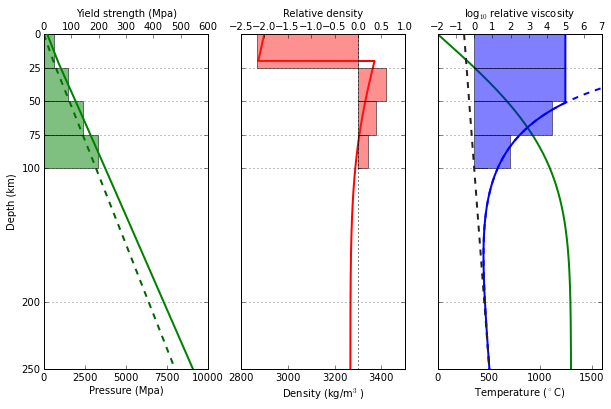

In [6]:
###########
# Plotting 
###########

%matplotlib inline

# define the plot explicitly so it can be twinned

figure1 = pypl.figure(figsize=(10,6))

# Global title (if needed)
# figure1.suptitle('Viscosity and Density Layering - {} Myr Oceanic Lithosphere, {} km oceanic crust\n'.format(timeMyrs,crustThickness), fontsize=14, fontweight='bold')

# first the temperature plot 

tempPlot = figure1.add_subplot(133)
tempPlot.plot(temp,depth,  color='green', linestyle='solid', linewidth=2, label='')
tempPlot.set_xlabel('Temperature ($^\circ$C)')
tempPlot.set_xlim(0,1600)
tempPlot.set_xticks([0,500,1000,1500])
tempPlot.set_yticks([0,25,50,75,100,200,250])
tempPlot.grid(axis='y')
tempPlot.invert_yaxis()
pypl.setp( tempPlot.get_yticklabels(), visible=False)


# now the viscosity plot

viscPlot = tempPlot.twiny()
viscPlot.plot(logViscosity_tr,depth, color='blue', linestyle='solid', linewidth=2, label='')
viscPlot.plot(logViscosity,depth, color='blue', linestyle='dashed', linewidth=2, label='')
viscPlot.plot(logViscosity_d,depth, color='#222222', linestyle='dashed', linewidth=2, label='')
viscPlot.set_xlabel('log$_{10}$ relative viscosity')
viscPlot.set_xlim(-2, 7)

# now add viscosity-average bars

viscPlot.barh(LayerTop[0:4],LayerLogAverageVisc[0:4], height=25.0, left=0.0, alpha=0.5)
viscPlot.barh(100.0, LayerLogAverageVisc[4], height=LayerTop[5]-LayerTop[4], left=0.0, alpha=0.5, linestyle='solid', hatch='//')

## Add density plot

densityPlot = figure1.add_subplot(132)
densityPlot.set_xlabel('Density (kg/m$^3$)')
densityPlot.set_xlim(2800,3500)
densityPlot.set_xticks([2800,3000,3200,3400])
densityPlot.set_yticks([0,25,50,75,100,200,250])
pypl.setp( densityPlot.get_yticklabels(), visible=False)

densityPlot.grid(axis='y')
densityPlot.plot(density,depth, color='red', linestyle='solid', linewidth=2, label='density (kg/m$^3$)')
densityPlot.invert_yaxis()

relDensityPlot = densityPlot.twiny()
relDensityPlot.set_xlabel('Relative density')
#relDensityPlot.set_xlim(-0.5, 1)
relDensityPlot.axvline(x=0, ymin=0, ymax=1, linestyle='dotted', color='black')

# now add relative density bars

relDensityPlot.barh(LayerTop[0:4],LayerAverageDensity[0:4], height=25.0, left=0.0, alpha=0.5, color='#FF2222')
relDensityPlot.barh(100.0, LayerAverageDensity[4], height=LayerTop[5]-LayerTop[4], left=0.0, alpha=0.5, fill='false', color='#FF2222', hatch='//')

## Add strength/pressure plot

pressurePlot = figure1.add_subplot(131)
pressurePlot.set_xlabel('Pressure (Mpa)')
# pressurePlot.set_xlim(2800,3300)

pressurePlot.set_yticks([0,25,50,75,100,200,250])
pressurePlot.plot(lithostaticPressure, depth, color='DarkGreen', linestyle='dashed', linewidth=2, label='pressure (MPa)')
pressurePlot.set_xticks([0,2500,5000,7500,10000])
pressurePlot.grid(axis='y')
pressurePlot.invert_yaxis()
pressurePlot.set_ylabel('Depth (km)')

pypl.setp( pressurePlot.get_yticklabels(), visible=True)


## Add the strength part 

strengthPlot = pressurePlot.twiny()
strengthPlot.set_xlabel('Yield strength (Mpa)')
strengthPlot.plot(yieldStrength, depth, color='green', linestyle='solid', linewidth=2, label='Yield strength (MPa)')

strengthPlot.barh(LayerTop[0:4],LayerAverageStrength[0:4], height=25.0, left=0.0, alpha=0.5, color='green')
# strengthPlot.barh(100.0, LayerAverageStrength[4], height=100.0, left=0.0, alpha=0.5, color='#EEFFEE', linestyle='solid', hatch='//')

# Save this to 

pdf = PdfPages('viscosityDensityPlot-{:.0f}Myr-{:.0f}km-P{:.0f}-{:.0f}km.pdf'.format(timeMyrs,crustThickness,plumeTop,plumeBase))
pypl.savefig(pdf, format='pdf') 
pdf.close()
